# Phase 3 Metrics
## Upload files

In [113]:
# Upload model
from google.colab import files
uploaded = files.upload()

In [ ]:
!unzip -qq necessary_files.zip
%cd necessary_files

--2021-06-11 13:40:21--  https://s3-us-west-2.amazonaws.com/static.pyimagesearch.com/real-time-object-detection-deep-learning/real-time-object-detection.zip
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.218.197.8
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.218.197.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21376463 (20M) [application/zip]
Saving to: ‘real-time-object-detection.zip’

real-time-object-de 100%[===================>]  20.39M  16.2MB/s    in 1.3s    

2021-06-11 13:40:22 (16.2 MB/s) - ‘real-time-object-detection.zip’ saved [21376463/21376463]

/content/real-time-object-detection


In [ ]:
from google.colab import files
uploaded = files.upload()

### Import Packages

In [ ]:
# import the necessary packages
from matplotlib import pyplot as plt
from imutils.video import FPS
import numpy as np
import argparse
import imutils
import cv2

### Function to display images in Jupyter Notebooks and Google Colab

In [ ]:
def plt_imshow(title, image):
	# convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

### Object detection in video with deep learning and OpenCV

In [ ]:
# first, let's get a video on which we can run our face mask detector 
!wget https://colab-notebook-videos.s3-us-west-2.amazonaws.com/janie.mp4

--2021-06-11 13:40:59--  https://colab-notebook-videos.s3-us-west-2.amazonaws.com/janie.mp4
Resolving colab-notebook-videos.s3-us-west-2.amazonaws.com (colab-notebook-videos.s3-us-west-2.amazonaws.com)... 52.218.224.57
Connecting to colab-notebook-videos.s3-us-west-2.amazonaws.com (colab-notebook-videos.s3-us-west-2.amazonaws.com)|52.218.224.57|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3413203 (3.3M) [video/mp4]
Saving to: ‘janie.mp4’

janie.mp4           100%[===================>]   3.25M  5.48MB/s    in 0.6s    

2021-06-11 13:41:00 (5.48 MB/s) - ‘janie.mp4’ saved [3413203/3413203]



In [ ]:
#@markdown # Declaration of initial parameters
#@markdown * Input video
#@markdown * Output video
#@markdown * probability for model
#@markdown * Model
#@markdown * Confidence
args = {
	"input" : "Subway.mp4",
	"output" : "output.avi",
	"prototxt": "MobileNetSSD_deploy.prototxt.txt",
	"model": "MobileNetSSD_deploy.caffemodel",
	"confidence" : 0.5
}

In [ ]:

CLASSES = ["background", "aeroplane", "bicycle", "bird", "boat",
	"bottle", "bus", "car", "cat", "chair", "cow", "diningtable",
	"dog", "horse", "motorbike", "person", "pottedplant", "sheep",
	"sofa", "train", "tvmonitor"]
COLORS = np.random.uniform(0, 255, size=(len(CLASSES), 3))

# load our serialized model from disk
print("[INFO] loading model...")
net = cv2.dnn.readNetFromCaffe(args["prototxt"], args["model"])

[INFO] loading model...


In [ ]:
# grab a reference to the video file, initialize pointer to output
# video file, and initialize the FPS counter
print("[INFO] opening video file...")
vs = cv2.VideoCapture(args["input"])
writer = None
fps = FPS().start()

[INFO] opening video file...


## Helpers

### Classes

In [ ]:
#Define rectangle based on two dots
class rectangle:
    def __init__(self, x1, y1, x2, y2):
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2
      
    def coordinates(self):
      return self.x1, self.y1, self.x2, self.y2

### Functions

In [ ]:
#Define if 2 rectangles are overlaped
def overlap(r1, r2):
    #Verifing first rectangle dots
    if (r1.x2>=r2.x1 and r1.x2 <=r2.x2 and r1.y2>=r2.y1 and r1.y2 <=r2.y2):
      return True
    if (r1.x1>=r2.x1 and r1.x1 <=r2.x2 and r1.y1>=r2.y1 and r1.y1 <=r2.y2):
      return True
    if (r1.x2>=r2.x1 and r1.x2 <=r2.x2 and r1.y1>=r2.y1 and r1.y1 <=r2.y2):
      return True
    if (r1.x1>=r2.x1 and r1.x1 <=r2.x2 and r1.y2>=r2.y1 and r1.y2 <=r2.y2):
      return True
    
    #Verifing second rectangle dots
    if (r2.x2>=r1.x1 and r2.x2 <=r1.x2 and r2.y2>=r1.y1 and r2.y2 <=r1.y2):
      return True
    if (r2.x1>=r1.x1 and r2.x1 <=r1.x2 and r2.y1>=r1.y1 and r2.y1 <=r1.y2):
      return True
    if (r2.x2>=r1.x1 and r2.x2 <=r1.x2 and r2.y1>=r1.y1 and r2.y1 <=r1.y2):
      return True
    if (r2.x1>=r1.x1 and r2.x1 <=r1.x2 and r2.y2>=r1.y1 and r2.y2 <=r1.y2):
      return True
    return False

#Count overlaped rectangles
def count_cases(rectangles):
    overlaped = 0
    for i in range(1,len(rectangles)):
        for j in range(1,len(rectangles)):
            if overlap(rectangles[0],rectangles[j]):
                overlaped +=1
                break
        rectangles.pop(0)    

    return overlaped


## Predict image

In [ ]:
def prediction(frame):
    # resize the frame to have a maximum width of 400 pixels
    frame = imutils.resize(frame, width=400)

    # grab the frame dimensions and convert it to a blob
    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 0.007843, (300, 300), 127.5)

    # pass the blob through the network and obtain the detections and
    # predictions
    net.setInput(blob)
    detections = net.forward()
    rectangles = []
  

     # loop over the detections
    for i in np.arange(0, detections.shape[2]):
        # extract the confidence (i.e., probability) associated with
        # the prediction
        confidence = detections[0, 0, i, 2]

        # filter out weak detections by ensuring the `confidence` is
        # greater than the minimum confidence
        if confidence > args["confidence"]:
            # extract the index of the class label from the
            # `detections`, then compute the (x, y)-coordinates of
            # the bounding box for the object
            idx = int(detections[0, 0, i, 1])
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX,startY,endX,endY) = box.astype("int")
            rectangles.append(rectangle(startX,startY,endX,endY))
            # draw the prediction on the frame
            label = "{}: {:.2f}%".format(CLASSES[idx],
                confidence * 100)
            cv2.rectangle(frame,(startX, startY), (endX, endY), COLORS[idx], 2)
            y = startY - 15 if startY - 15 > 15 else startY + 15
        #Variables used for add rectangles to $total_rectangles    
        aux = []
        for i,j in enumerate(rectangles):
            aux.append(j)

    overlaped = count_cases(rectangles)
    return bool(overlaped)

In [ ]:
#Define the image to predict
image = cv2.imread("/content/overlap.jpeg")
print(image.shape)
  

(392, 640, 3)


In [ ]:
#to predict the case of the image
prediction(image)
!pwd

/content/real-time-object-detection


##Evaluation Metrics

In [ ]:
#unzip the dataset_validation
!unzip -qq /content/overlaped.zip
!unzip -qq /content/non_overlaped.zip

In [ ]:
import pandas as pd
from sklearn import metrics
import seaborn as sn
df = pd.read_csv('/content/dataset.csv')
df['y_pred'] = [prediction(x) for x in [cv2.imread(y) for y in df['filename']]]
df

,filename,y_test,y_pred
0,/content/non_overlaped/img_0001.jpg,0,True
1,/content/non_overlaped/img_0002.jpg,0,False
2,/content/non_overlaped/img_0003.jpg,0,True
3,/content/non_overlaped/img_0004.jpg,0,False
4,/content/non_overlaped/img_0005.jpg,0,True
...,...,...,...
195,/content/overlaped/img_0096.jpg,1,True
196,/content/overlaped/img_0097.jpg,1,True
197,/content/overlaped/img_0098.jpg,1,True
198,/content/overlaped/img_0099.jpg,1,True


In [ ]:
print("Accuracy: ",metrics.accuracy_score(df["y_test"], df["y_pred"]))
print("Precision: ",metrics.precision_score(df["y_test"], df["y_pred"]))
print("Recall: ", metrics.recall_score(df["y_test"], df["y_pred"], average='weighted'))
Accuracy = metrics.accuracy_score(df["y_test"], df["y_pred"])*100
Precision = metrics.precision_score(df["y_test"], df["y_pred"])*100
Recall = metrics.recall_score(df["y_test"], df["y_pred"], average='weighted')*100

Accuracy:  0.76
Precision:  0.703125
Recall:  0.76


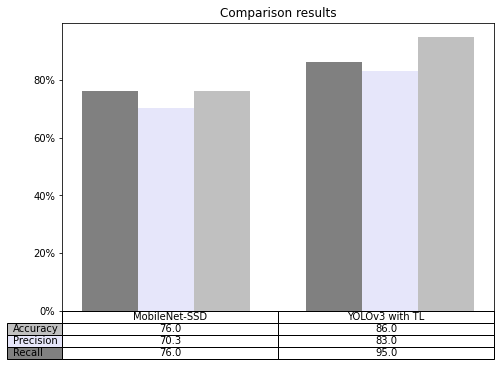

In [112]:
import numpy as np
import matplotlib.pyplot as plt
datap = [[Accuracy, 86],
[Precision, 83],
[Recall, 95]]

columns = ('MobileNet-SSD', 'YOLOv3 with TL')
rows = ['Accuracy', 'Precision', 'Recall']

data = [            ['MobileNet-SSD', 'YOLOv3 with TL'],
        ['Accuracy', Accuracy, 86],
        ['Precision', Precision, 83],
        ['Recall', Recall, 95]
]

column_headers = data.pop(0)
row_headers = [x.pop(0) for x in data]

cell_text = []
for row in data:
    cell_text.append([f'{x:1.1f}' for x in row])

X = np.arange(2)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, datap[0], color = '#808080', width = 0.25)
ax.bar(X + 0.25, datap[1], color = '#e6e6fa', width = 0.25)
ax.bar(X + 0.50, datap[2], color = '#c0c0c0', width = 0.25)

ax.set_title('Comparison results')
ax.set_yticks([0,20,40,60,80])
yticks = ['0%', '20%', '40%', '60%', '80%']
ax.set_yticklabels(yticks)
ax.get_xaxis().set_visible(False)
colors = ['#808080', '#e6e6fa', '#c0c0c0']
colors = colors[::-1]
the_table = plt.table(cellText=cell_text,
                      cellLoc='center',
                      rowLabels=row_headers,
                      rowColours=colors,
                      colLabels=column_headers,
                      loc='bottom')
plt.savefig('table.eps', format='eps', bbox_inches = 'tight')

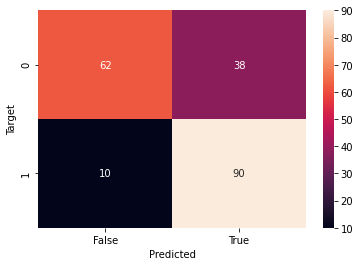

In [ ]:
confusion_matrix = pd.crosstab(df["y_test"], df["y_pred"], rownames=['Target'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True)
plt.savefig('figure.eps', format='eps')

In [ ]:
average = "weighted" #@param ["macro", "micro", "weighted"]


print("F1 score: ",metrics.f1_score(df["y_test"], df["y_pred"], average=average))

F1 score:  0.7552019583843329


In [ ]:
print(metrics.recall_score(df["y_test"], df["y_pred"], average='macro'))
print(metrics.recall_score(df["y_test"], df["y_pred"], average='micro'))
print(metrics.recall_score(df["y_test"], df["y_pred"], average='weighted'))

0.76
0.76
0.76


In [ ]:
print(metrics.classification_report(df["y_test"], df["y_pred"]))

              precision    recall  f1-score   support

           0       0.86      0.62      0.72       100
           1       0.70      0.90      0.79       100

    accuracy                           0.76       200
   macro avg       0.78      0.76      0.76       200
weighted avg       0.78      0.76      0.76       200

